## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [89]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [90]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=2, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    #output_layer = layers.GaussianDropout(0.001)(output_layer) 
    
    output_layer = layers.SpatialDropout2D(0.25)(output_layer) 
    
    output_layer = layers.BatchNormalization()(output_layer) 
    
    output_layer = layers.SpatialDropout2D(0.25)(output_layer) 
    
    
    
    #output_layer = layers.Dropout(0.2)(output_layer) 
    
    return output_layer

#try batchnorm first
#skip activation
#apply relu after batchnorm


def conv2d_batchnorm(input_layer, filters, kernel_size=1, strides=1):
    
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same',activation='relu')(input_layer)
    
    #output_layer = layers.Dropout(0.25)(output_layer) 
    
    #output_layer = layers.SpatialDropout2D(0.25, data_format=None)(output_layer) 
    
    output_layer = layers.BatchNormalization()(output_layer) 
    
    output_layer = layers.Dropout(0.25)(output_layer) 
    
    #output_layer = layers.Dropout(0.1)(output_layer) 
    
    
    return output_layer

In [92]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

In [93]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    upsampled = bilinear_upsample(small_ip_layer)
    
    print("upsampled size %s large_ip_layer size %s"%(np.shape(upsampled),np.shape(large_ip_layer)))
    
    concatenated = layers.concatenate([upsampled, large_ip_layer],axis=3)
    output_layer = separable_conv2d_batchnorm(concatenated, filters, strides=1)
    
    return output_layer

In [94]:
def fcn_model(inputs, num_classes):
    
    print("inputs %s"%np.shape(inputs))
        
    encode_1 = encoder_block(inputs, 50, 2)
    print("encode_1 %s"%np.shape(encode_1))
    
    encode_2 = encoder_block(encode_1, 100, 2)
    print("encode_2 %s"%np.shape(encode_2))
    
    encode_3 = encoder_block(encode_2, 150, 2)
    print("encode_3 %s"%np.shape(encode_3))
    
    encode_4 = encoder_block(encode_3, 200, 2)
    print("encode_3 %s"%np.shape(encode_4))
    

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    convolution_layer = conv2d_batchnorm(encode_4, 250, 1, 1)
    print("convol_l %s"%np.shape(convolution_layer))
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decode_1 = decoder_block(convolution_layer, encode_3, 200)
    print("decode_1 %s"%np.shape(decode_1))
    
    decode_2 = decoder_block(decode_1, encode_2, 150)
    print("decode_2 %s"%np.shape(decode_2))
    
    decode_3 = decoder_block(decode_2, encode_1, 100)
    print("decode_3 %s"%np.shape(decode_3))
    
    decode_4 = decoder_block(decode_3, inputs, 50)
    print("decode_3 %s"%np.shape(decode_4))

    x = decode_4
    print("output %s"%np.shape(x))
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
   
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

In [95]:
image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

inputs (?, 160, 160, 3)
encode_1 (?, 80, 80, 50)
encode_2 (?, 40, 40, 100)
encode_3 (?, 20, 20, 150)
encode_3 (?, 10, 10, 200)
convol_l (?, 10, 10, 250)
upsampled size (?, 20, 20, 250) large_ip_layer size (?, 20, 20, 150)
decode_1 (?, 20, 20, 200)
upsampled size (?, 40, 40, 200) large_ip_layer size (?, 40, 40, 100)
decode_2 (?, 40, 40, 150)
upsampled size (?, 80, 80, 150) large_ip_layer size (?, 80, 80, 50)
decode_3 (?, 80, 80, 100)
upsampled size (?, 160, 160, 100) large_ip_layer size (?, 160, 160, 3)
decode_3 (?, 160, 160, 50)
output (?, 160, 160, 50)


In [102]:
learning_rate = 0.00001
batch_size = 10
num_epochs = 4
steps_per_epoch = 200
validation_steps = 100
workers = 4

Epoch 1/4
199/200 [============================>.] - ETA: 1s - loss: 0.0652

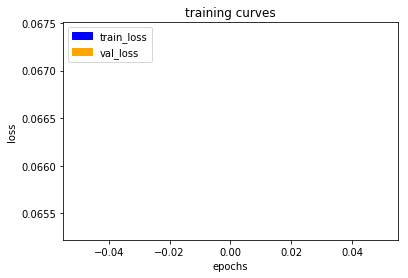

200/200 [==============================] - 425s - loss: 0.0652 - val_loss: 0.0674
Epoch 2/4
199/200 [============================>.] - ETA: 1s - loss: 0.0664

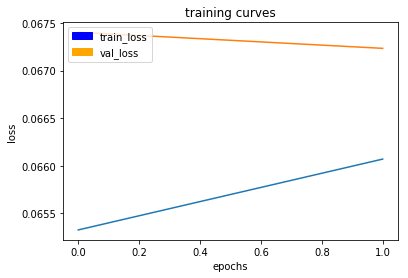

200/200 [==============================] - 420s - loss: 0.0663 - val_loss: 0.0672
Epoch 3/4
199/200 [============================>.] - ETA: 1s - loss: 0.0656

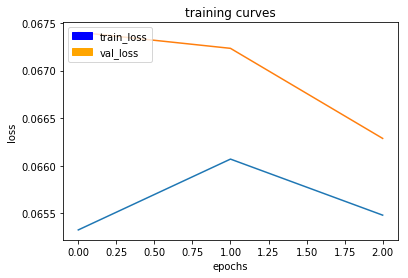

200/200 [==============================] - 420s - loss: 0.0656 - val_loss: 0.0663
Epoch 4/4
199/200 [============================>.] - ETA: 1s - loss: 0.0656

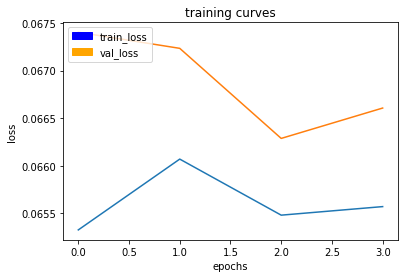

200/200 [==============================] - 420s - loss: 0.0656 - val_loss: 0.0666


In [103]:
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)